# -------------------------**Multiple Disease prediction**-------------------------------

## Kidney disease

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from xgboost import XGBClassifier


In [3]:
# Load dataset
df = pd.read_csv('kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
# Drop unnecessary column
df.drop('id', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [6]:
# Replace placeholders with np.nan
df.replace(['?', 'NaN', 'nan', 'NULL'], np.nan, inplace=True)


In [7]:
# Convert numeric-like columns stored as text into numbers
for col in ['pcv', 'wc', 'rc']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [8]:
# Strip and lowercase text columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()


In [9]:
# Encode target with binary 1=ckd, 0=notckd
df['classification'] = df['classification'].str.strip()
y = (df['classification'] == 'ckd').astype(int)
X = df.drop(columns=['classification'])

In [10]:
# Separate categorical and numerical columns for preprocessing
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()


In [11]:
# Split dataset early to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
# Impute numeric and categorical separately on train
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [13]:
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(num_imputer.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train[cat_cols]), columns=cat_cols, index=X_train.index)
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

In [14]:
# Encode categorical features using LabelEncoder trained only on train
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col])
    X_test_cat[col] = le.transform(X_test_cat[col])
    label_encoders[col] = le

In [15]:
# Combine processed numeric and categorical features
X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_proc = pd.concat([X_test_num, X_test_cat], axis=1)

In [16]:
# Scale numeric features - fit only on train
scaler = StandardScaler()
X_train_proc[num_cols] = scaler.fit_transform(X_train_proc[num_cols])
X_test_proc[num_cols] = scaler.transform(X_test_proc[num_cols])

In [17]:
# Apply SMOTE only on train data to balance classes after splitting
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

In [18]:
print("\nTraining class distribution after SMOTE:\n", pd.Series(y_train_res).value_counts())


Training class distribution after SMOTE:
 classification
1    200
0    200
Name: count, dtype: int64


In [19]:
# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}
    

In [20]:
results = {}
conf_matrixes = {}
roc_curves = {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train, cross-validate, and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    scores = cross_val_score(model, X_train_res, y_train_res, cv=kfold, scoring='accuracy')
    model.fit(X_train_res, y_train_res)

    y_pred = model.predict(X_test_proc)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_proc)[:, 1]
    else:
        y_proba = model.decision_function(X_test_proc)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    results[name] = {'cv_accuracy': scores.mean(), 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc_auc}
    conf_matrixes[name] = cm
    roc_curves[name] = (fpr, tpr)


Training LogisticRegression...

Training DecisionTree...

Training RandomForest...


In [21]:
# Metrics table
metrics_df = pd.DataFrame(results)
print("\nCross-validation & test metrics per model:\n", metrics_df)

metrics_df.to_csv('model_comparison_kidney_no_xgb.csv')



Cross-validation & test metrics per model:
              LogisticRegression  DecisionTree  RandomForest
cv_accuracy            0.995000      0.992500         0.995
accuracy               0.975000      0.962500         1.000
precision              1.000000      1.000000         1.000
recall                 0.960000      0.940000         1.000
f1                     0.979592      0.969072         1.000
roc_auc                1.000000      0.970000         1.000


In [22]:
# Find best model by test accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")



Best model: RandomForest with accuracy: 1.0000


In [23]:
# Save best model
with open('best_model_kidney.pkl', 'wb') as f:
    pickle.dump(best_model, f)


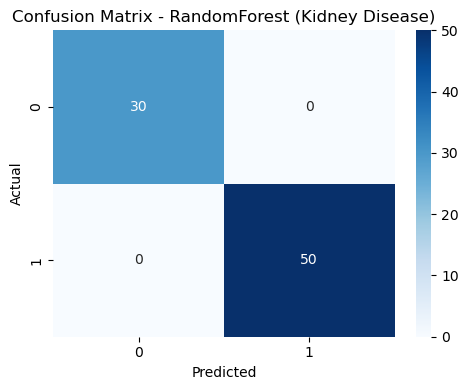

In [24]:
# Plot confusion matrix of best model
best_cm = conf_matrixes[best_model_name]
plt.figure(figsize=(5, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} (Kidney Disease)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


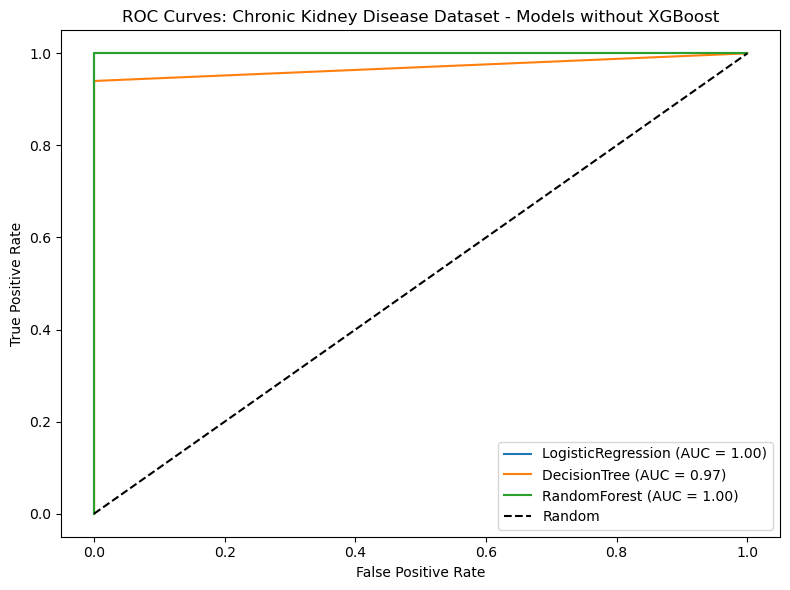

In [25]:
# ROC curves for remaining models
plt.figure(figsize=(8, 6))
for name in models.keys():
    fpr, tpr = roc_curves[name]
    auc = results[name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Chronic Kidney Disease Dataset - Models without XGBoost')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()